In [1]:
""" Experiment Settings """
depth_tree, depth_query = 5, 5
threshold_size = 100
times = 10
flag = True
res = []

In [2]:
""" Libraries """
import json
import numpy as np
import pandas as pd
import psycopg2
from matplotlib import pyplot as plt

import nbimporter
from Core import Ranges, nDTree, tree_shape_relation, draw_lines, draw_points, draw_box, experiment_execution

In [14]:
""" Database Connection """
conn_params = "dbname='trajectory' user='postgres' host='localhost' password='990721' port=5432"
conn = psycopg2.connect(conn_params)
cur = conn.cursor()

573it [00:00, 2359.39it/s]


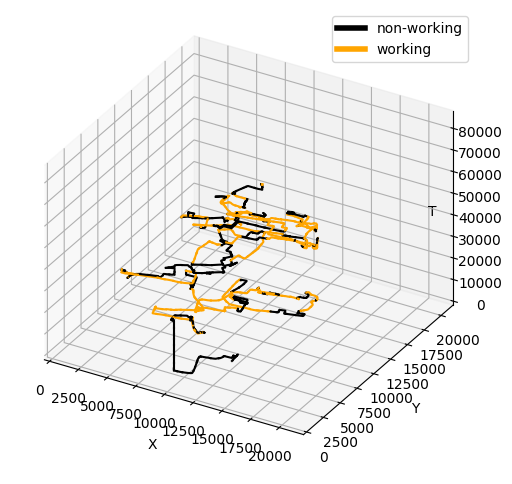

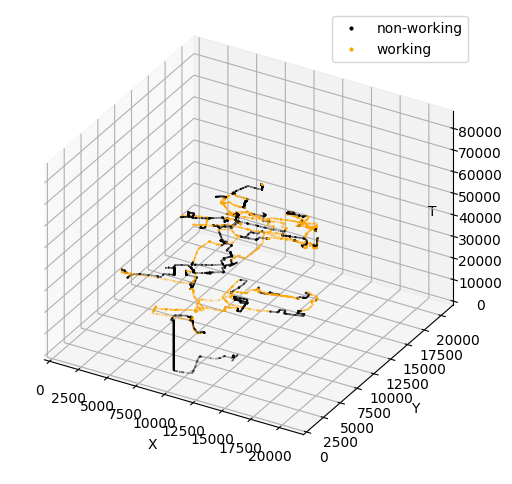

In [16]:
sql_first_trajectory = """
SELECT st_astext(geometry) AS geometry, state
FROM traj_{} AS t,
     (SELECT DISTINCT taxiid
FROM traj_{}
WHERE taxiid IS NOT NULL
LIMIT 1) AS taxi_table
WHERE t.taxiid = taxi_table.taxiid;
""".format(depth_tree, depth_tree)

cur.execute(sql_first_trajectory)
records = cur.fetchall()
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)
draw_lines(df, "sequences")
draw_points(df, "points", 0.1)

{'min': [0.1, 0.1, 0.1], 'max': [0.3, 0.3, 0.3]}


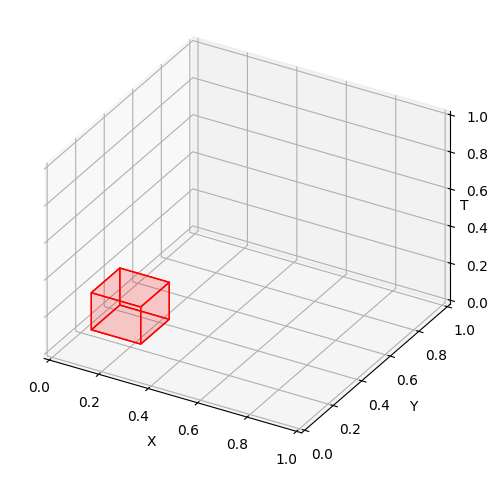

In [123]:
""" Experiment Preparation: read parameters """
with open("para.json", "r") as json_file:
    para = json.load(json_file)
fold_para = para["fold_para"]
with open("{}/para_{}.json".format(fold_para, depth_tree), "r") as json_file:
    para = json.load(json_file)

dist = para["dist"]
x_scl = para["x_scl"]
y_scl = para["y_scl"]
t_scl = para["t_scl"]
""" Experiment Preparation: set query shape """
queryShape = {"min": [0.1, 0.1, 0.1], "max": [0.3, 0.3, 0.3]}
print(queryShape)
draw_box(queryShape, "t3")

In [124]:
""" Experiment Preparation: calculate ranges """
index_scale = 2 ** depth_tree
queryShape["min"] = [coord * index_scale for coord in queryShape["min"]]
queryShape["max"] = [coord * index_scale for coord in queryShape["max"]]
print(queryShape)

# initialize tree
tree = nDTree(depth_tree, dist, threshold_size)
# calculate ranges
values = tree.shapeQuery(queryShape, depth_query, tree_shape_relation)
# initialize ranges (do clean merge)
ranges_merged = Ranges(values)
# only the relevant ranges
ranges = [(range[0], range[1]) for range in ranges_merged.rangeList() if range[2] == 1 or range[2] == 0]
res.append(len(ranges))
# create query condition
condition = ' OR '.join(['(%s <= indexing_key AND indexing_key <= %s )' % (r[0], r[1]) for r in ranges])

{'min': [12.8, 12.8, 12.8], 'max': [38.4, 38.4, 38.4]}
contained, continue 0 2097151
contained, continue 0 262143
intersected, continue 0 32767
intersected, continue 0 4095
outside 2048 2559
intersected, continue 16384 20479
outside 16384 16895
outside 16896 17407
outside 18432 18943
outside 18944 19455
intersected, continue 20480 24575
outside 20480 20991
outside 20992 21503
outside 22528 23039
outside 23040 23551
intersected, continue 23552 24063
outside 23808 23871
intersected, continue 24064 24575
outside 24384 24447
intersected, continue 24576 28671
outside 25600 26111
outside 27648 28159
intersected, continue 32768 65535
outside 45056 49151
intersected, continue 49152 53247
outside 49152 49663
outside 49664 50175
outside 51200 51711
outside 51712 52223
intersected, continue 52224 52735
outside 52288 52351
outside 52480 52543
outside 52544 52607
intersected, stop 52672 52735
outside 52736 53247
outside 53248 57343
intersected, continue 57344 61439
intersected, stop 58368 58879
int

In [125]:
""" Experiment Preparation: create range table """
sql_range_table = """
DROP TABLE IF EXISTS range_table;
CREATE TABLE range_table
(
    range_left  INT,
    range_right INT
);
"""
cur.execute(sql_range_table)

sql_insert_range = """
INSERT INTO range_table (range_left, range_right)
VALUES (%s, %s);"""

for rng in ranges:
    cur.execute(sql_insert_range, rng)
conn.commit()

In [126]:
""" SQL Expression """
sql_expression = """
SELECT st_astext(geometry) AS geometry, state
FROM traj_{}
WHERE ({}) AND (geometry IS NOT NULL);
""".format(depth_tree, condition)

""" SQL Range Join """
sql_rangeJoin = """
SELECT st_astext(geometry) AS geometry, state
FROM traj_{} AS t JOIN range_table AS r
ON t.indexing_key BETWEEN r.range_left AND r.range_right
WHERE t.geometry IS NOT NULL;
""".format(depth_tree)

In [127]:
""" Expression Query without Indexing """
timings = []
print("experiment expression")
records = experiment_execution(times, timings, sql_expression, cur, flag)
res.append(len(records))
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))

""" Range Join Query without Indexing """
timings = []
print("experiment range join")
records = experiment_execution(times, timings, sql_rangeJoin, cur, flag)
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))

experiment expression


100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


timings: [0.35147690773010254, 0.3386814594268799, 0.33734893798828125, 0.3557436466217041, 0.34569740295410156, 0.3552701473236084, 0.3470878601074219, 0.452803373336792, 0.4667537212371826, 0.41180992126464844]
median: 0.35337352752685547
experiment range join


100%|██████████| 10/10 [00:37<00:00,  3.73s/it]

timings: [9.82634711265564, 2.982741594314575, 2.9805471897125244, 3.013254165649414, 3.0297014713287354, 3.0332727432250977, 3.028449535369873, 3.0750060081481934, 3.0875954627990723, 3.245540142059326]
median: 3.0314871072769165


In [128]:
sql_traj_index = """
DROP INDEX IF EXISTS traj_index_indexing_key;
CREATE INDEX traj_index_indexing_key ON traj_{} USING btree (indexing_key);
""".format(depth_tree)

cur.execute(sql_traj_index)
conn.commit()

In [129]:
""" Expression Query with Indexing """
timings = []
print("experiment expression")
records = experiment_execution(times, timings, sql_expression, cur, flag)
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))

""" Range Join Query with Indexing """
timings = []
print("experiment range join")
records = experiment_execution(times, timings, sql_rangeJoin, cur, flag)
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))

experiment expression


100%|██████████| 10/10 [00:00<00:00, 15.34it/s]


timings: [0.0936281681060791, 0.06900668144226074, 0.05640387535095215, 0.0629587173461914, 0.06249642372131348, 0.0628972053527832, 0.0628817081451416, 0.06250667572021484, 0.05659985542297363, 0.0625462532043457]
median: 0.06271398067474365
experiment range join


100%|██████████| 10/10 [00:37<00:00,  3.76s/it]

timings: [3.1193625926971436, 3.0471997261047363, 3.221817970275879, 3.5003809928894043, 7.507260322570801, 3.0902187824249268, 3.0659244060516357, 3.3756906986236572, 3.3007144927978516, 4.404330253601074]
median: 3.2612662315368652


998it [00:00, 1090.35it/s]


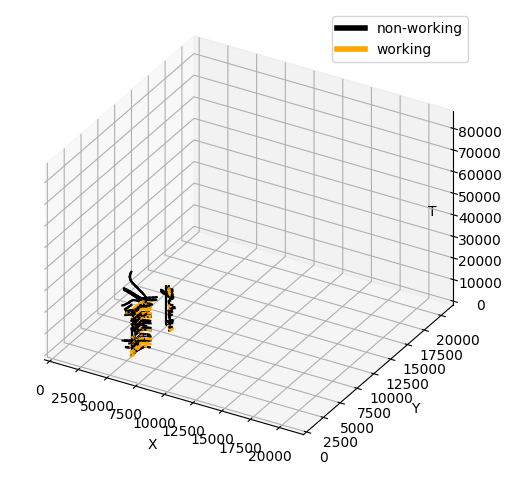

In [130]:
""" Visualization Selection """
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)
draw_lines(df, "t3-{}".format(depth_tree))

In [131]:
""" Delete Index """
sql_delete_index = """
DROP INDEX IF EXISTS traj_index_indexing_key;
""".format(depth_tree)

cur.execute(sql_delete_index)
conn.commit()

In [132]:
cur.close()
conn.close()

In [133]:
print(res)

[15, 998, 0.35337352752685547, 3.0314871072769165, 0.06271398067474365, 3.2612662315368652]


In [3]:
depth_tree = [0, 1, 2, 3, 4, 5, 6, 7]
res_0 = [1, 49303, 0.30042338371276855, 1.5547970533370972, 1.5922491550445557, 1.469152808189392]
res_1 = [1, 6608, 0.07921600341796875, 0.12618756294250488, 0.04717862606048584, 0.1972578763961792]
res_2 = [1, 8710, 0.0787651538848877, 0.14344191551208496, 0.05193042755126953, 0.22849857807159424]
res_3 = [10, 2204, 0.07887065410614014, 0.22014212608337402, 0.015639424324035645, 0.28917837142944336]
res_4 = [16, 164, 0.09497368335723877, 0.473751425743103, 0.0, 0.5000941753387451]
res_5 = [15, 255, 0.12561607360839844, 0.8787597417831421, 0.0, 0.8730854988098145]
res_6 = [15, 473, 0.18851757049560547, 1.5878489017486572, 0.06368494033813477, 1.6288974285125732]
res_7 = [15, 998, 0.35337352752685547, 3.0314871072769165, 0.06271398067474365, 3.2612662315368652]

In [4]:
num_range = []
num_record = []
expression_without_index = []
rangeJoin_without_index = []
expression_with_index = []
rangeJoin_with_index = []

all_res = [res_0, res_1, res_2, res_3, res_4, res_5, res_6, res_7]

for res in all_res:
    num_range.append(res[0])
    num_record.append(res[1])
    expression_without_index.append(res[2])
    rangeJoin_without_index.append(res[3])
    expression_with_index.append(res[4])
    rangeJoin_with_index.append(res[5])

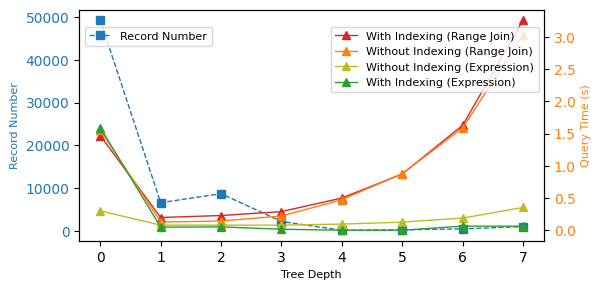

In [12]:
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.set_xlabel('Tree Depth', fontdict={"fontsize": 8})
ax1.set_ylabel('Record Number', color='tab:blue', fontdict={"fontsize": 8})
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.plot(depth_tree, num_record, label='Record Number', color='tab:blue', marker='s', linewidth=1, linestyle='--')

ax2 = ax1.twinx()
ax2.set_ylabel('Query Time (s)', color='tab:orange', fontdict={"fontsize": 8})
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.plot(depth_tree, rangeJoin_with_index, label='With Indexing (Range Join)', color='tab:red', marker='^', linewidth=1)
ax2.plot(depth_tree, rangeJoin_without_index, label='Without Indexing (Range Join)', color='tab:orange', marker='^', linewidth=1)
ax2.plot(depth_tree, expression_without_index, label='Without Indexing (Expression)', color='tab:olive', marker='^', linewidth=1)
ax2.plot(depth_tree, expression_with_index, label='With Indexing (Expression)', color='tab:green', marker='^', linewidth=1)

ax1.legend(fontsize=8, loc='upper left', bbox_to_anchor=(0, 0.95))
ax2.legend(fontsize=8, loc='upper right', bbox_to_anchor=(1, 0.95))
fig.savefig("figs/selection.pdf", bbox_inches='tight')
plt.show()

In [155]:
print(num_range)
print(num_record)
print([round(val, 2) for val in expression_without_index])
print([round(val, 2) for val in rangeJoin_without_index])
print([round(val, 2) for val in expression_with_index])
print([round(val, 2) for val in rangeJoin_with_index])

[1, 1, 1, 10, 16, 15, 15, 15]
[49303, 6608, 8710, 2204, 164, 255, 473, 998]
[0.3, 0.08, 0.08, 0.08, 0.09, 0.13, 0.19, 0.35]
[1.55, 0.13, 0.14, 0.22, 0.47, 0.88, 1.59, 3.03]
[1.59, 0.05, 0.05, 0.02, 0.0, 0.0, 0.06, 0.06]
[1.47, 0.2, 0.23, 0.29, 0.5, 0.87, 1.63, 3.26]
